In [13]:
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sys
import pandas as pd
from anomatools.models import SSDO
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from tensorflow.keras import layers, models
%matplotlib inline

%reload_ext autoreload
%autoreload 2

df_total = pd.read_csv('eps_all.csv')

In [14]:
def preprocessing(ip):
    print(ip)
    df = df_total[df_total['ip']==ip].sort_values(by='create_time').reset_index(drop=True)
    if len(df) < 24:
        return False

    df['create_time'] = pd.to_datetime(df['create_time'])
    df.set_index('create_time', inplace=True)
    # Create a new index with hourly frequency and fill missing hours with NaN
    new_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')

    # Reindex the DataFrame with the new index and fill NaN with 0
    df = df.reindex(new_index, fill_value=0)

    # Reset the index to make 'create_time' a column again
    df.reset_index(inplace=True)

    min_value = 0.2
    max_value = 0.8
    max_count = df['count'].max()
    min_count = df['count'].min()

    df['day_of_week'] = df['index'].dt.dayofweek
    df['time'] = df['index'].dt.time
    df['count'] = min_value+(max_value-min_value)*(df['count']-min_count)/(max_count-min_count)
    first_index = df.index[(df['time'] == pd.to_datetime('00:00:00').time())].min()

    # Display the resulting DataFrame
    #print(df[first_sunday_index:])
    data = []
    for i in range(int(len(df[first_index:])/24)):
        temp = df[24*i:(i+1)*24]['count'].values.tolist()
        if temp.count(0.2) >12:
            #print('None log message today')
            continue
        week = [0]*7
        week[df.iloc[24*i]['day_of_week']]  = 1
        temp.extend(week)
        #print(temp)
        data.append(temp)
    #total.extend(data)

    df = pd.DataFrame(data)
    #Transform and scale data
    return df
df = preprocessing('192.168.61.1')#.to_numpy()
print(df)

X_train = df.to_numpy()

192.168.61.1
           0         1         2         3         4         5         6   \
0    0.200146  0.200157  0.200138  0.200141  0.200126  0.200139  0.200161   
1    0.200114  0.200108  0.200113  0.200108  0.200106  0.200110  0.200158   
2    0.200119  0.200135  0.200125  0.200134  0.200190  0.200198  0.200147   
3    0.200117  0.200132  0.200116  0.200119  0.200116  0.200115  0.200154   
4    0.200119  0.200120  0.200101  0.200088  0.200080  0.200080  0.200108   
..        ...       ...       ...       ...       ...       ...       ...   
348  0.200206  0.200206  0.200202  0.200223  0.200212  0.200226  0.200212   
349  0.200213  0.200204  0.200191  0.200175  0.200215  0.200211  0.200207   
350  0.200223  0.200227  0.200196  0.200217  0.200194  0.200219  0.200204   
351  0.200219  0.200205  0.200210  0.200196  0.200239  0.200210  0.200206   
352  0.200220  0.200226  0.200237  0.200223  0.200227  0.200231  0.200217   

           7         8         9   ...        21        22    

In [15]:
input_dim = X_train.shape[1]  # Input dimension


# Define the encoder
encoder = models.Sequential([
    layers.InputLayer(input_shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu')
])

# Define the decoder
decoder = models.Sequential([
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(input_dim, activation='sigmoid')
])

In [16]:
# Combine encoder and decoder to create autoencoder
autoencoder = models.Sequential([encoder, decoder])

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder on your unlabeled data
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, shuffle=True)

Epoch 1/10
12/12 [==============================] - 1s 3ms/step - loss: 0.1199
Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0971
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0554
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0365
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0311
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0287
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0276
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0273
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0271
Epoch 10/10
12/12 [==============================] - 0s 1ms/step - loss: 0.0268


In [17]:
# Now, you can use the trained autoencoder for anomaly detection
# Evaluate on the training set to set a threshold for anomaly detection
train_reconstructions = autoencoder.predict(X_train)
train_mse = np.mean(np.square(X_train - train_reconstructions), axis=1)

12/12 [==============================] - 0s 1ms/step


In [19]:
train_reconstructions

array([[0.20875753, 0.20109624, 0.18870737, ..., 0.12597921, 0.13260424,
        0.17925233],
       [0.1857829 , 0.18804193, 0.19947183, ..., 0.1339852 , 0.1191699 ,
        0.14524947],
       [0.2015495 , 0.19948125, 0.1917132 , ..., 0.12954271, 0.1340518 ,
        0.16271034],
       ...,
       [0.19340658, 0.20474064, 0.1967004 , ..., 0.13517924, 0.12978175,
        0.16292477],
       [0.20346704, 0.19042762, 0.18442851, ..., 0.12470041, 0.13389868,
        0.16372585],
       [0.20865546, 0.2009839 , 0.18860382, ..., 0.1258815 , 0.13250563,
        0.17913787]], dtype=float32)

1/1 [==============================] - 0s 21ms/step


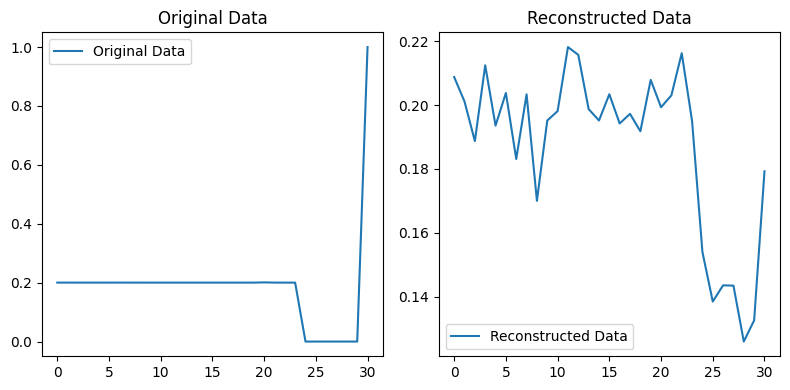

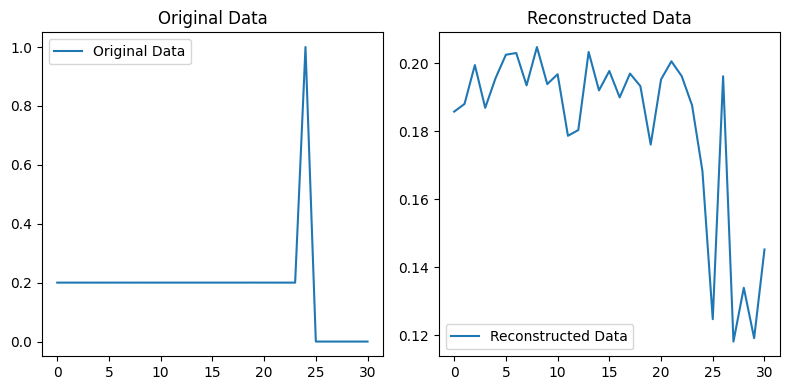

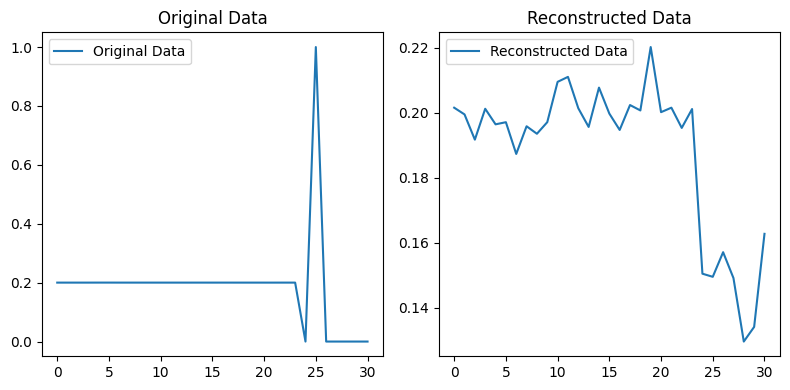

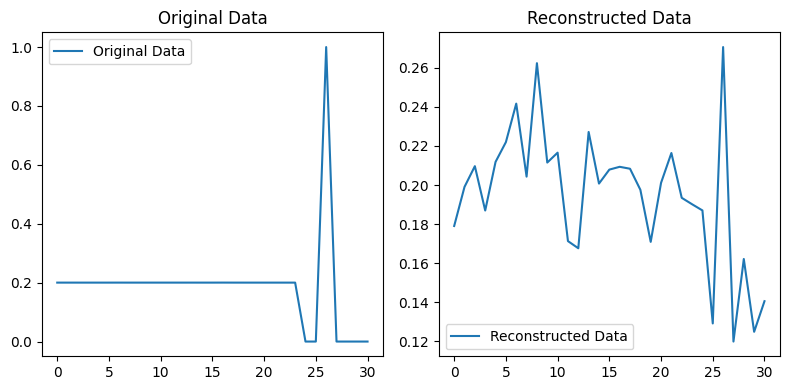

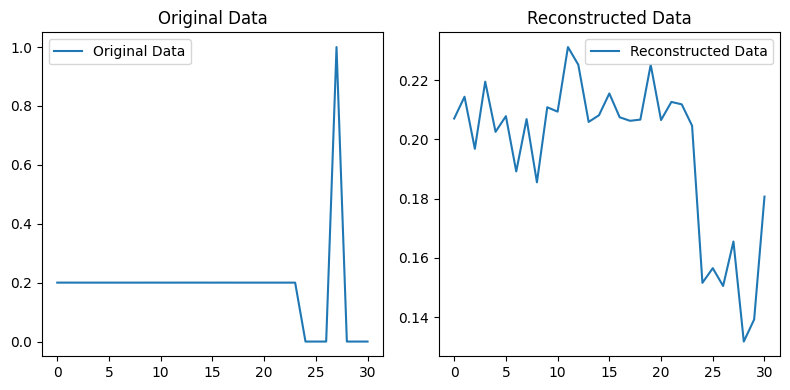

In [20]:
import matplotlib.pyplot as plt

# Assuming X_test is your test data without labels
num_samples_to_plot = 5  # Number of samples to plot

# Select a few samples for visualization
samples_to_plot = X_train[:num_samples_to_plot]

# Predict using the autoencoder
reconstructions = autoencoder.predict(samples_to_plot)

# Plot the original and reconstructed data
for i in range(num_samples_to_plot):
    plt.figure(figsize=(8, 4))

    # Plot original data
    plt.subplot(1, 2, 1)
    plt.plot(samples_to_plot[i], label='Original Data')
    plt.title('Original Data')
    plt.legend()

    # Plot reconstructed data
    plt.subplot(1, 2, 2)
    plt.plot(reconstructions[i], label='Reconstructed Data')
    plt.title('Reconstructed Data')
    plt.legend()

    plt.tight_layout()
    plt.show()